<a href="https://colab.research.google.com/github/GU-DPM/EvolutionaryClassifier/blob/main/analysis/notebooks/Analyze_2_move_DPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [ ]:
# First setup credentials to link to drive.
# Not necesarry if Survial and Parameters file is not stored on Drive.
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# install to generate KP plots and Hazard Ratios
# revome "%% capture" to view output
%%capture
! pip install lifelines

In [ ]:
# import DPM population objects/functions
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter


class TrialPopulation:
    def __init__(self, df, population_id=None):
        self.entries = df.to_dict(orient='records')
        self.population_id = population_id
        self.hazard_ratio_cpm_dpm = None
        self.hazard_ratio_cpm_dpmtrial = None

    def __getitem__(self, index):
        return self.entries[index]

    def __len__(self):
        return len(self.entries)

    def to_dataframe(self, file_path=None):
        df = pd.DataFrame(self.entries)
        if file_path:
            df.to_csv(file_path, index=False)
        return df


    def add_benefit_columns(self, min_survival_days=60, min_percent_benefit=25):
        df = self.to_dataframe()
        df['benefit_DPM'] = (
            (df['Survival_DPM'] - df['Survival_CPM'] >= min_survival_days) &
            ((df['Survival_DPM'] - df['Survival_CPM']) / df['Survival_CPM'] >= min_percent_benefit / 100)
        )
        df['benefit_DPMtrial'] = (
            (df['Survival_DPMtrial'] - df['Survival_CPM'] >= min_survival_days) &
            ((df['Survival_DPMtrial'] - df['Survival_CPM']) / df['Survival_CPM'] >= min_percent_benefit / 100)
        )
        df['Extraordinary_Benefit'] = (
            df['benefit_DPMtrial'] &
            (df['Survival_DPM'] - df['Survival_DPMtrial'] >= min_survival_days) &
            ((df['Survival_DPM'] - df['Survival_DPMtrial']) / df['Survival_DPMtrial'] >= min_percent_benefit / 100)
        )
        self.entries = df.to_dict(orient='records')

    def plot_km(self, file_path=None):
        df = self.to_dataframe()
        if file_path and os.path.exists(file_path):
            print(f"The plot already exists at {file_path}. Displaying the plot.")
            img = plt.imread(file_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            return

        kmf = KaplanMeierFitter()
        plt.figure(figsize=(10, 6))
        label_mapping = {
            'Survival_CPM': 'CPM',
            'Survival_DPM': '40-move DPM',
            'Survival_DPMtrial': '2-move DPM'
        }

        for column in ['Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial']:
            kmf.fit(df[column], event_observed=[1]*len(df))
            kmf.plot_survival_function(label=label_mapping[column])

        plt.title(f'Survival Curves for {self.population_id or "Population"} (n={len(df)})', fontsize=20)
        plt.xlabel('Days', fontsize=16)
        plt.ylabel('Survival Probability', fontsize=16)
        plt.legend(fontsize=18)

        if file_path:
            plt.savefig(file_path)
            print(f"The plot has been saved to {file_path}.")
        else:
            plt.show()

    def calc_hazard_ratio(self, file_path=None):
        df = self.to_dataframe()
        if file_path and os.path.exists(file_path):
            print(f"The file already exists at {file_path}. Loading and printing the content.")
            with open(file_path, 'r') as f:
                print(f.read())
            return

        output = []

        # CPM vs DPM
        df_long = pd.melt(df, id_vars=['Parameter_ID'], value_vars=['Survival_CPM', 'Survival_DPM'],
                          var_name='Survival_Type', value_name='Days')
        df_long['Event'] = 1
        df_long = pd.get_dummies(df_long, columns=['Survival_Type'], drop_first=True)
        cph = CoxPHFitter()
        cph.fit(df_long, duration_col='Days', event_col='Event', formula='Survival_Type_Survival_DPM')
        self.hazard_ratio_cpm_dpm = cph.hazard_ratios_['Survival_Type_Survival_DPM']

        output.append(f"Hazard Ratio between Survival_CPM and Survival_DPM for {self.population_id or 'population'}:")
        output.append(str(cph.summary))

        # CPM vs DPMtrial
        df_long2 = pd.melt(df, id_vars=['Parameter_ID'], value_vars=['Survival_CPM', 'Survival_DPMtrial'],
                           var_name='Survival_Type', value_name='Days')
        df_long2['Event'] = 1
        df_long2 = pd.get_dummies(df_long2, columns=['Survival_Type'], drop_first=True)
        cph2 = CoxPHFitter()
        cph2.fit(df_long2, duration_col='Days', event_col='Event', formula='Survival_Type_Survival_DPMtrial')
        self.hazard_ratio_cpm_dpmtrial = cph2.hazard_ratios_['Survival_Type_Survival_DPMtrial']

        output.append(f"\nHazard Ratio between Survival_CPM and Survival_DPMtrial for {self.population_id or 'population'}:")
        output.append(str(cph2.summary))

        print('\n'.join(output))

        if file_path:
            with open(file_path, 'w') as f:
                f.write('\n'.join(output))
            print(f"The output has been saved to {file_path}.")

        return pd.DataFrame({
            'Comparison': ['Survival_CPM vs Survival_DPM', 'Survival_CPM vs Survival_DPMtrial'],
            'Hazard_Ratio': [self.hazard_ratio_cpm_dpm, self.hazard_ratio_cpm_dpmtrial],
            'Population_ID': [self.population_id, self.population_id]
        })


    def subset_pop_by_params(self, population_id=None, **thresholds):
        """
        Returns a new TrialPopulation object with rows filtered by min/max thresholds.

        Parameters:
        population_id (str or None): ID for the new subset population. Defaults to None.
        thresholds (dict): Keys are column names, values are (min, max) tuples.

        Returns:
        TrialPopulation: A new object with the filtered subset.
        """
        df = self.to_dataframe()
        for column, (min_val, max_val) in thresholds.items():
            df = df[(df[column] >= min_val) & (df[column] <= max_val)]
        return TrialPopulation(df, population_id=population_id)

    def subset_by_ec_category(self, allowed_categories, population_id=None):
        """
        Returns a new TrialPopulation object with rows filtered by allowed EC_category values.

        Parameters:
        allowed_categories (list of str): List of allowed EC_category values.
        population_id (str or None): ID for the new subset population. Defaults to None.

        Returns:
        TrialPopulation: A new object with the filtered subset.
        """
        df = self.to_dataframe()
        df = df[df['EC_category'].isin(allowed_categories)]
        return TrialPopulation(df, population_id=population_id)

    def calculate_statistics(self):
        df = self.to_dataframe()
        numeric_columns = [
            'Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial',
            'S_pop', 'R1_pop', 'R2_pop', 'R12_pop', 'g0',
            'S_cell_sensitivity_D1', 'S_cell_sensitivity_D2',
            'R1_cell_sensitivity_D1', 'R1_cell_sensitivity_D2',
            'R2_cell_sensitivity_D1', 'R2_cell_sensitivity_D2',
            'R12_cell_sensitivity_D1', 'R12_cell_sensitivity_D2',
            'S_transition_to_R1', 'S_transition_to_R2', 'R1_transition_to_R12',
            'R2_transition_to_R12'
        ]

        stats = {}
        for column in numeric_columns:
            stats[column] = {
                'min': df[column].min(),
                'max': df[column].max(),
                'mean': df[column].mean(),
                'median': df[column].median(),
                'std': df[column].std()
            }

        ec_category_distribution = df['EC_category'].value_counts().to_dict()
        stats['EC_category_distribution'] = ec_category_distribution

        return stats


    def calculate_statistics(self):
        df = self.to_dataframe()
        numeric_columns = [
            'Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial',
            'S_pop', 'R1_pop', 'R2_pop', 'R12_pop', 'g0',
            'S_cell_sensitivity_D1', 'S_cell_sensitivity_D2',
            'R1_cell_sensitivity_D1', 'R1_cell_sensitivity_D2',
            'R2_cell_sensitivity_D1', 'R2_cell_sensitivity_D2',
            'R12_cell_sensitivity_D1', 'R12_cell_sensitivity_D2',
            'S_transition_to_R1', 'S_transition_to_R2', 'R1_transition_to_R12',
            'R2_transition_to_R12'
        ]

        stats = {}
        for column in numeric_columns:
            stats[column] = {
                'min': df[column].min(),
                'max': df[column].max(),
                'mean': df[column].mean(),
                'median': df[column].median(),
                'std': df[column].std()
            }

            # Violin plot
            plt.figure(figsize=(10, 6))
            sns.violinplot(x=df[column], inner="box", color="skyblue")
            plt.title(f'Violin Plot for {column}', fontsize=16)
            plt.xlabel(column, fontsize=14)
            plt.ylabel('Density', fontsize=14)
            plt.grid(True)
            plt.show()

        # EC_category distribution
        ec_category_distribution = df['EC_category'].value_counts().to_dict()
        stats['EC_category_distribution'] = ec_category_distribution

        # Bar plot for EC_category
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(ec_category_distribution.keys()), y=list(ec_category_distribution.values()), palette="pastel")
        plt.title('EC_category Distribution', fontsize=16)
        plt.xlabel('EC_category', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.grid(True)
        plt.show()

        return stats



# Defining the Simulated Population

We will use the pan-cancer simulation that covers all the input space for the 2-drug, non-reversable resistance model. The file "EC_survival_and_params.csv" contains the full model parameters and survival information for 3,083,233 simulated patients.

Update the file path to point to the correct file.

In [ ]:
import os
import pandas as pd

sim_data_dir = '/content/drive/MyDrive/dpmTrialResults/output_mapping_Oct24/SimulatedClinicalTrailApp'
pop_survival_and_param_file = 'EC_survival_and_params.csv'
population_df = pd.read_csv(os.path.join(sim_data_dir, pop_survival_and_param_file))


Each row corresponds to a single patient, identified by the "Parameter ID" column.

The Survival_CPM, Survival_DPM, and Survival_DPMtrial columns record the number of days each patient survives using the respective strategy. DPMtrial applies DPM for the first two treatment windows, then reverts to the CPM selection strategy.

The final output column is the "EC_categoy". This referes to the Evolutionary classifier described in https://ascopubs.org/doi/10.1200/PO.23.00714. In short, this is the differce in the drug choice between DPM and CPM. This can be

The remaining columns are the model parameters, and the set of which are unique for each "Parameter ID". There are:  
* The intial subclonal populations ('S_pop', 'R1_pop', 'R2_pop', 'R12_pop'
* Their baseline growth rate 'g0'
* The subclone drug sensitivities for each drug ('S_cell_sensitivity_D1', S_cell_sensitivity_D2', 'R1_cell_sensitivity_D1', 'R1_cell_sensitivity_D2',, 'R2_cell_sensitivity_D1', 'R2_cell_sensitivity_D2', 'R12_cell_sensitivity_D1', 'R12_cell_sensitivity_D2')
* The evolutionary transition rates ('S_transition_to_R1', S_transition_to_R2', 'R1_transition_to_R12', 'R2_transition_to_R12'

In [ ]:
population_df.columns

Index(['Parameter_ID', 'Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial',
       'EC_category', 'S_pop', 'R1_pop', 'R2_pop', 'R12_pop', 'g0',
       'S_cell_sensitivity_D1', 'S_cell_sensitivity_D2',
       'R1_cell_sensitivity_D1', 'R1_cell_sensitivity_D2',
       'R2_cell_sensitivity_D1', 'R2_cell_sensitivity_D2',
       'R12_cell_sensitivity_D1', 'R12_cell_sensitivity_D2',
       'S_transition_to_R1', 'S_transition_to_R2', 'R1_transition_to_R12',
       'R2_transition_to_R12'],
      dtype='object')

In [ ]:
population_df['EC_category'].unique()

array(['both_diff', 'both_same', 'first_same_only', 'second_same_only'],
      dtype=object)

# Trial Population Analysis

The TrialPopulation object lets you perform some baseline population analysis and survival statistics that show the performance of treatment selection stratigies.

In [ ]:
wholeTrialPopulation = TrialPopulation(population_df,population_id='full_simulation')

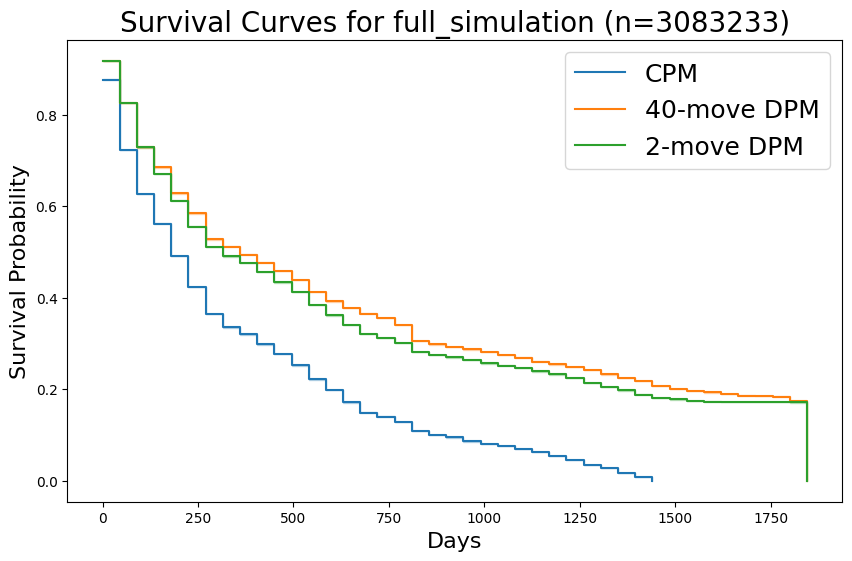

In [ ]:
wholeTrialPopulation.plot_km()

In [ ]:
wholeTrialPopulation.calc_hazard_ratio()

Hazard Ratio between Survival_CPM and Survival_DPM for full_simulation:
                                coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                   
Survival_Type_Survival_DPM -0.696382   0.498385  0.000886       -0.698119   

                            coef upper 95%  exp(coef) lower 95%  \
covariate                                                         
Survival_Type_Survival_DPM       -0.694646              0.49752   

                            exp(coef) upper 95%  cmp to           z    p  \
covariate                                                                  
Survival_Type_Survival_DPM             0.499251     0.0 -785.950398  0.0   

                            -log2(p)  
covariate                             
Survival_Type_Survival_DPM       inf  

Hazard Ratio between Survival_CPM and Survival_DPMtrial for full_simulation:
                                     coef  exp(coef)  se(coef)  \
cova

,Comparison,Hazard_Ratio,Population_ID
0,Survival_CPM vs Survival_DPM,0.498385,full_simulation
1,Survival_CPM vs Survival_DPMtrial,0.538499,full_simulation


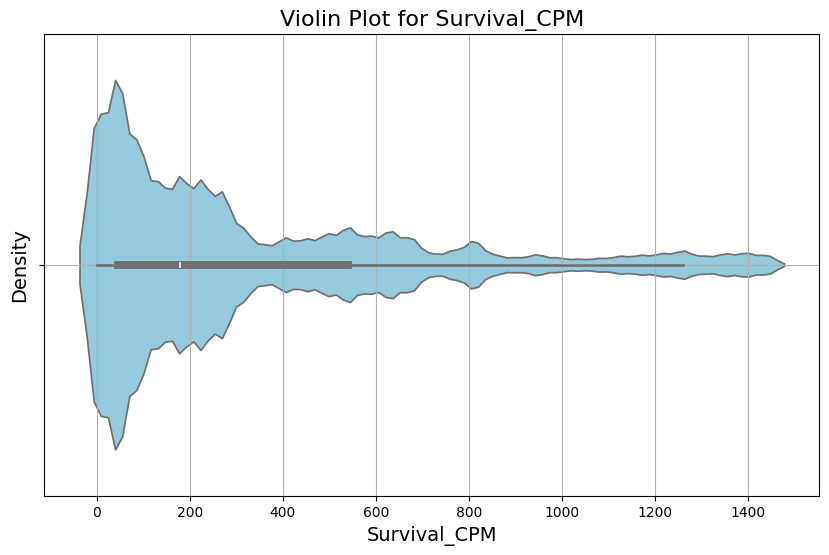

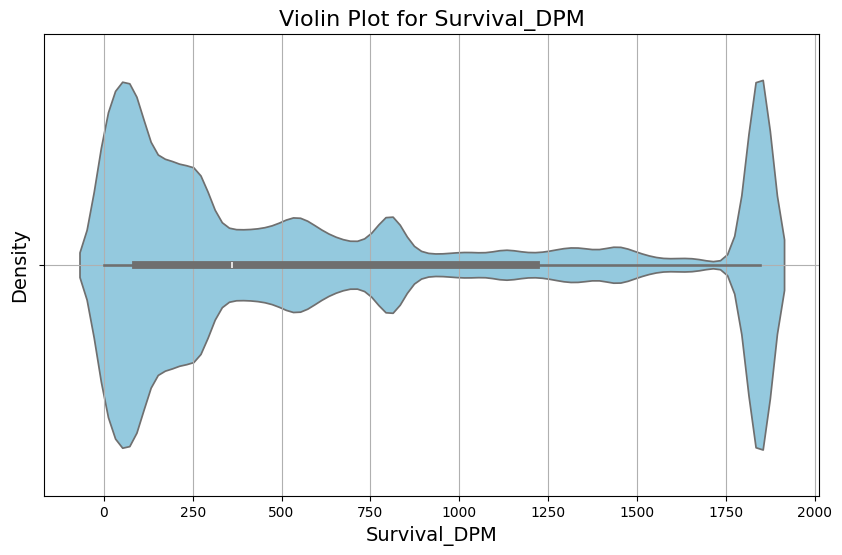

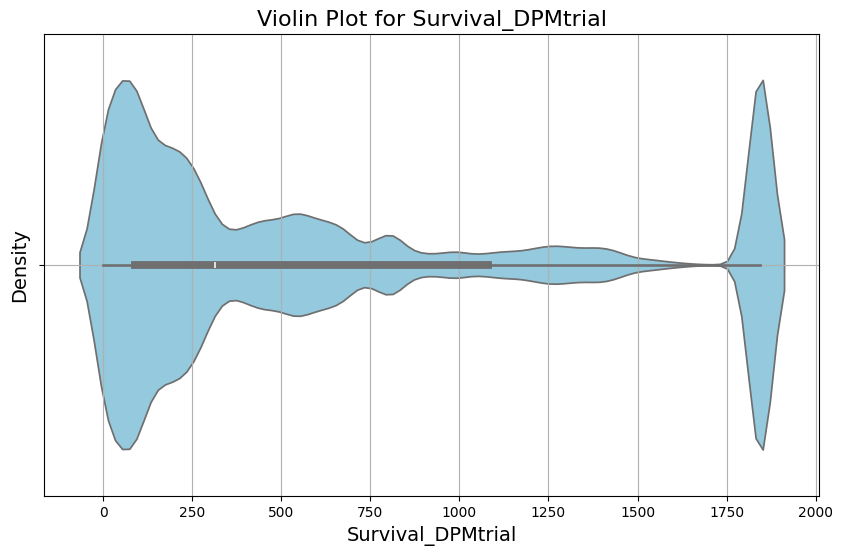

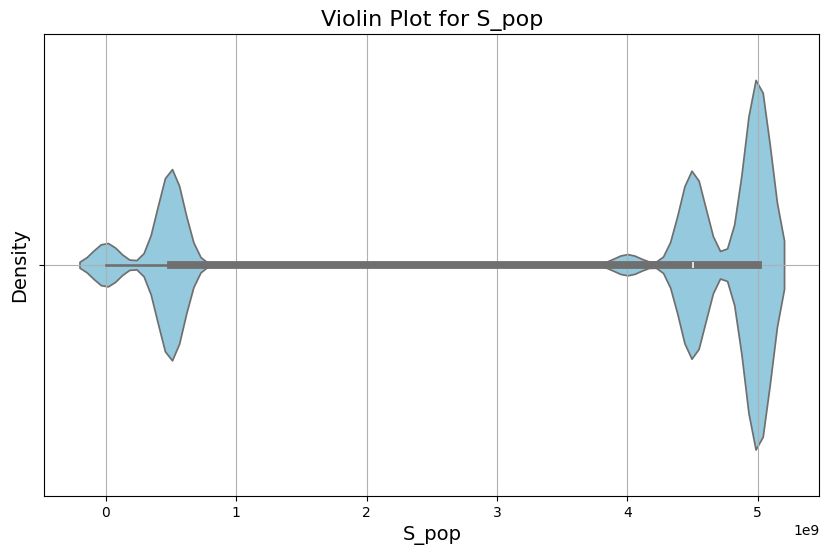

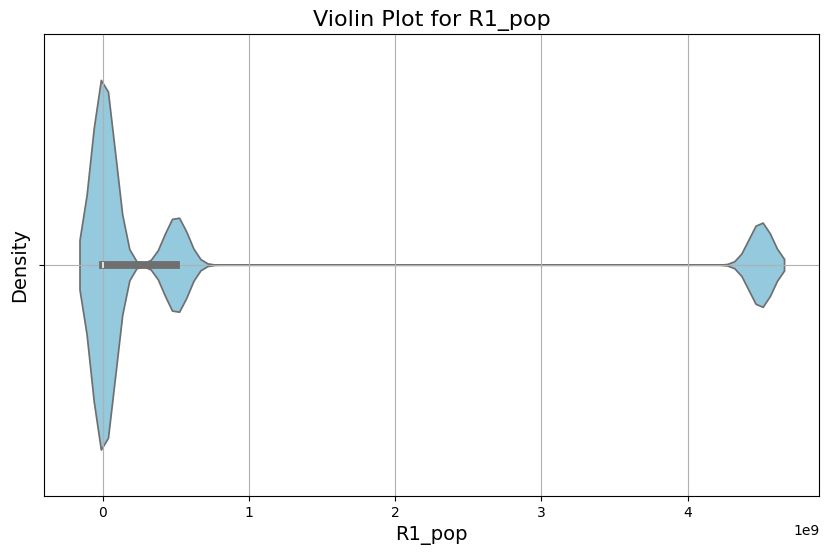

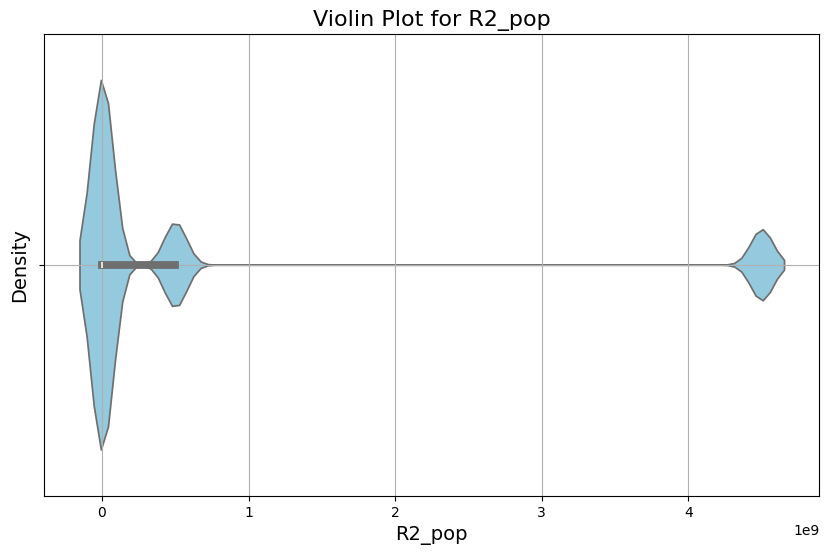

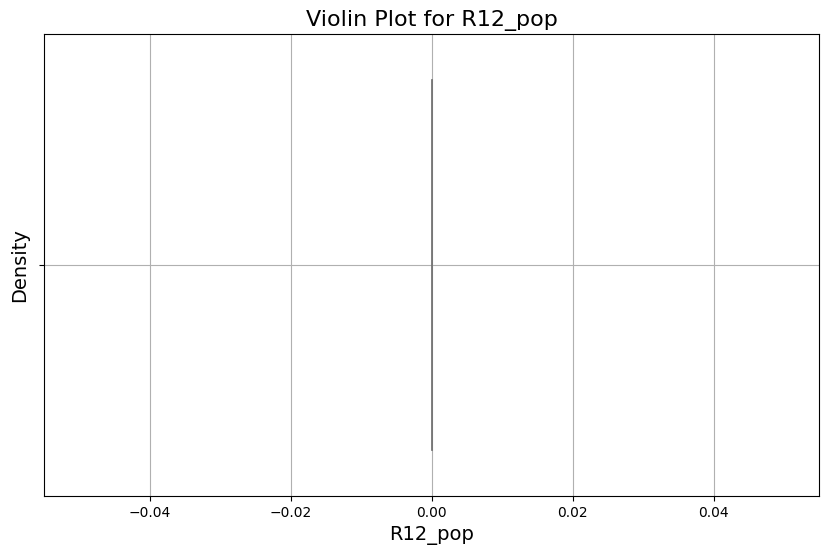

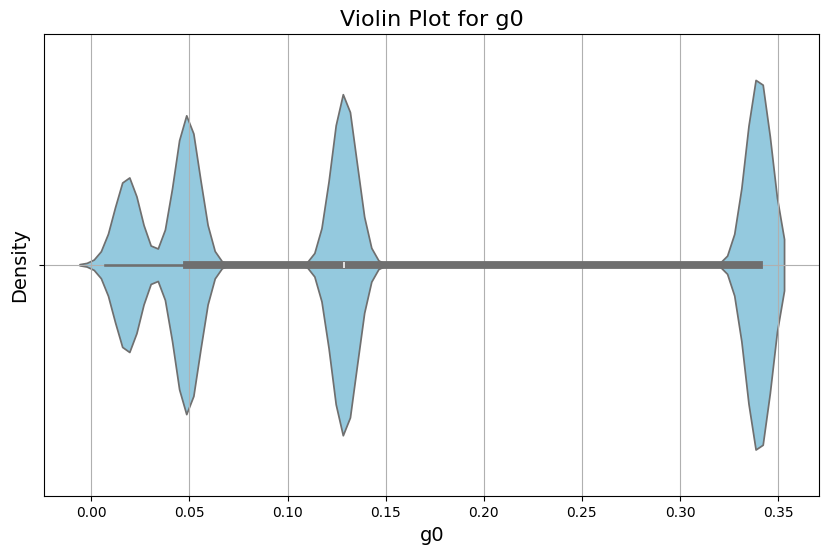

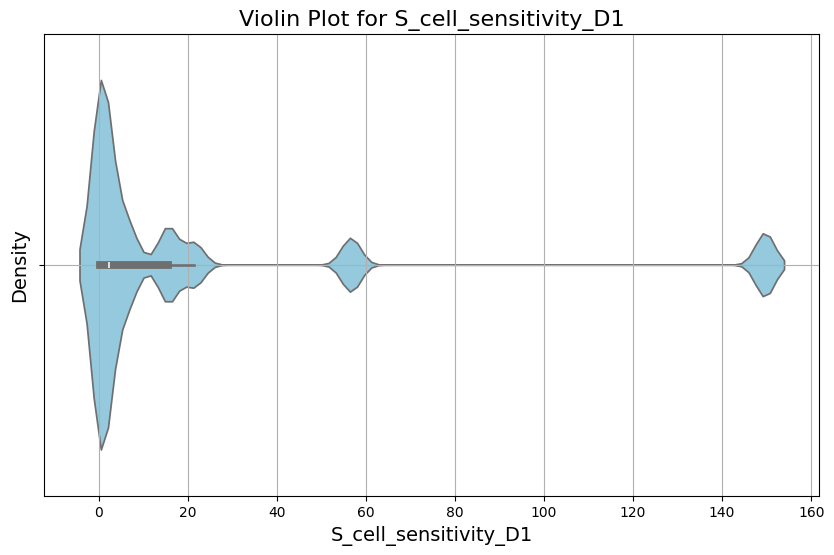

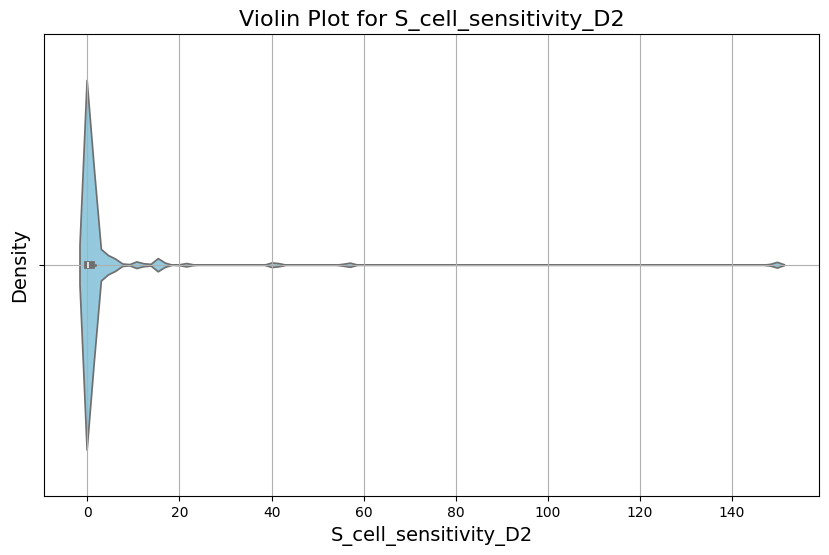

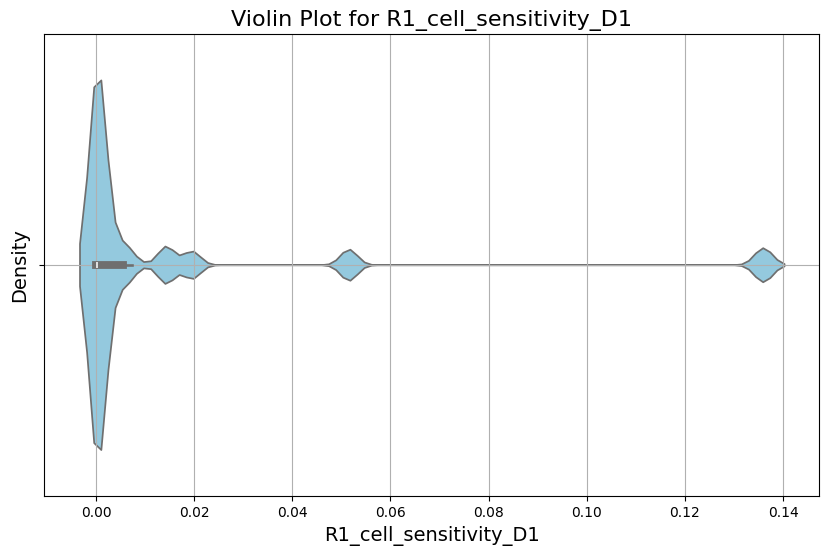

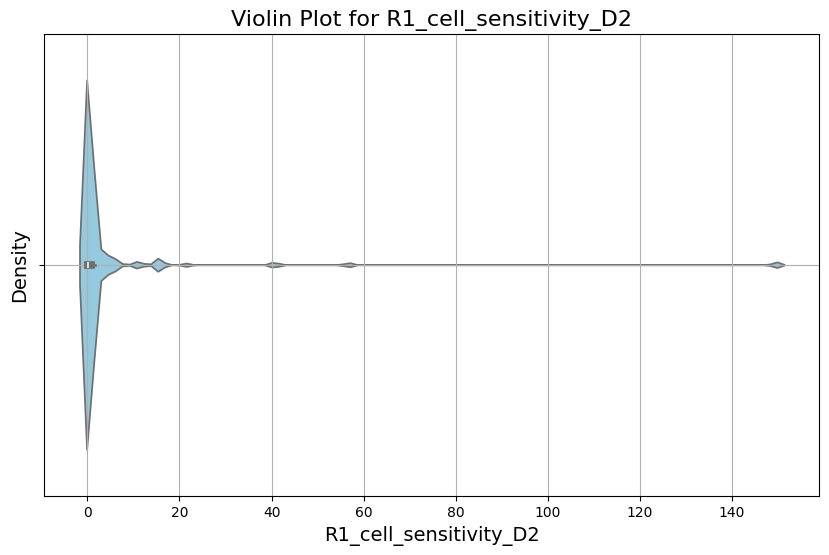

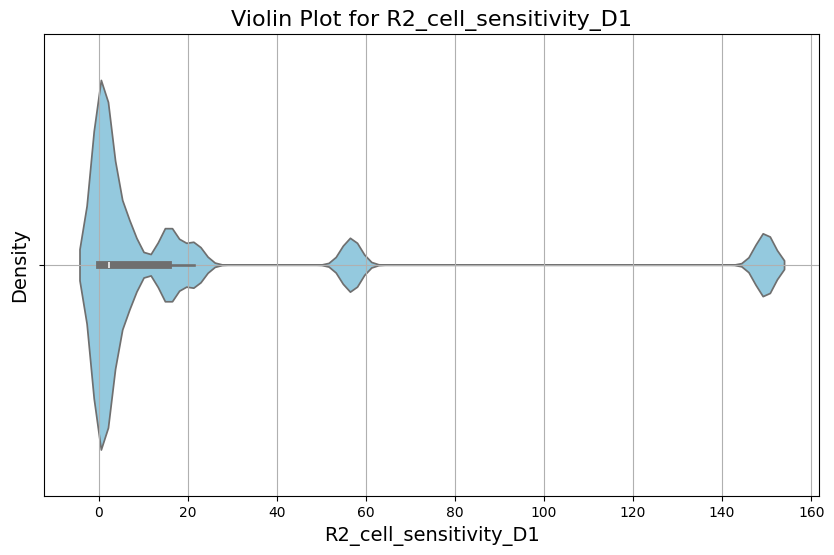

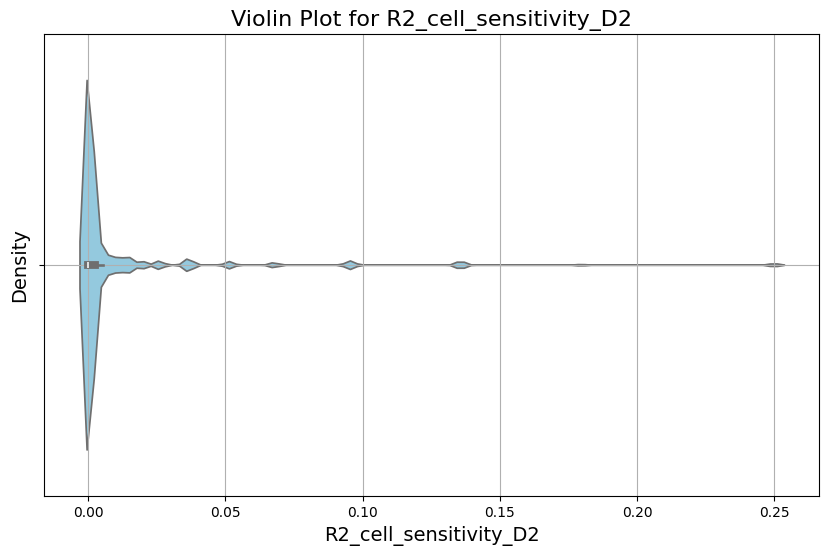

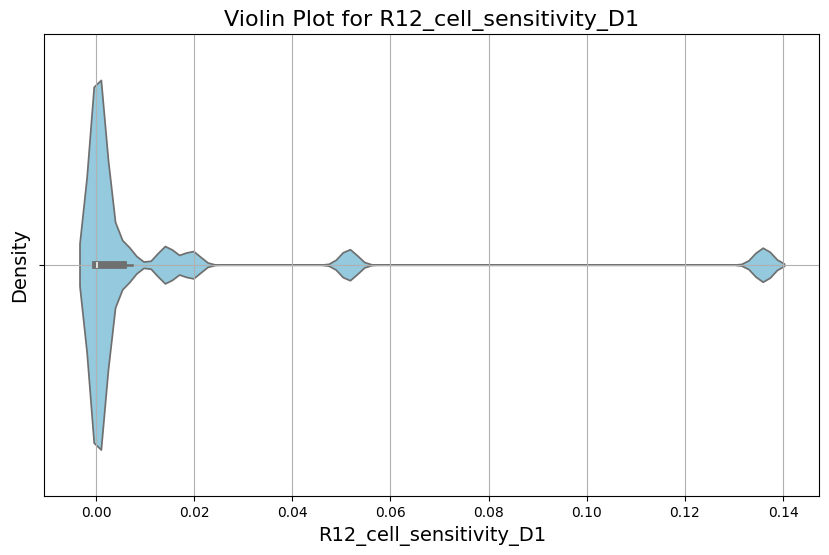

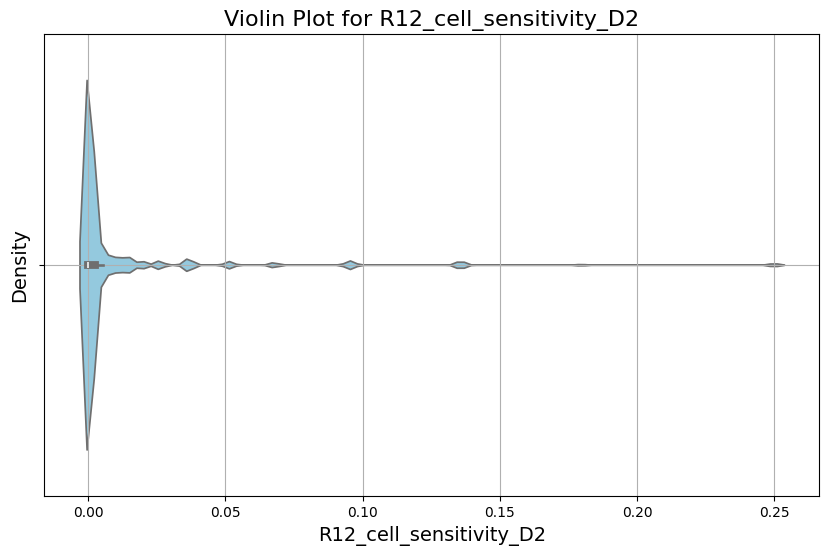

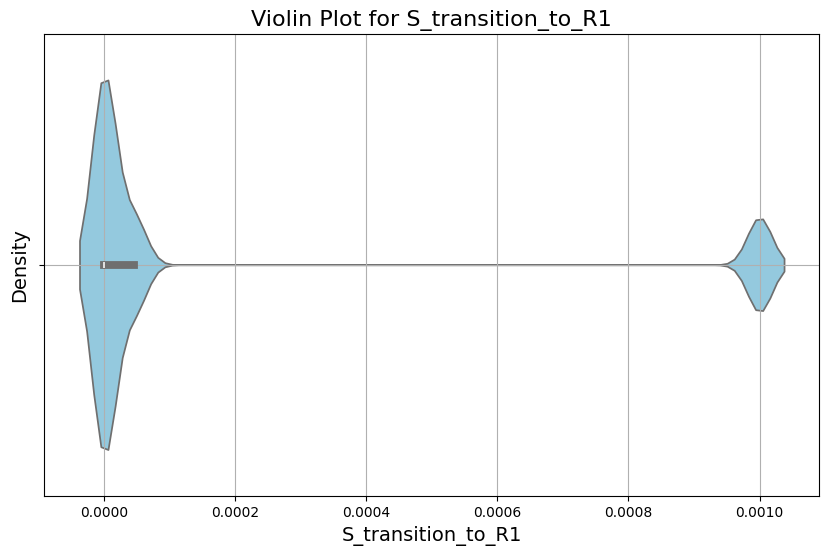

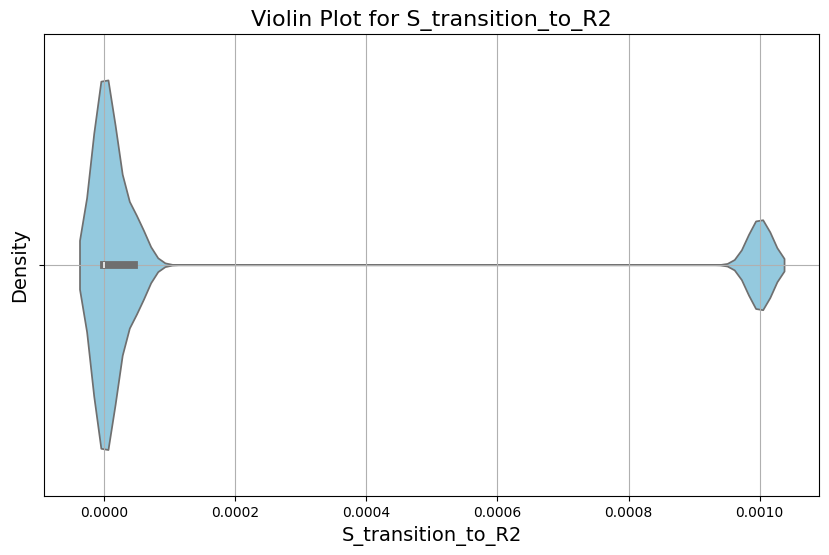

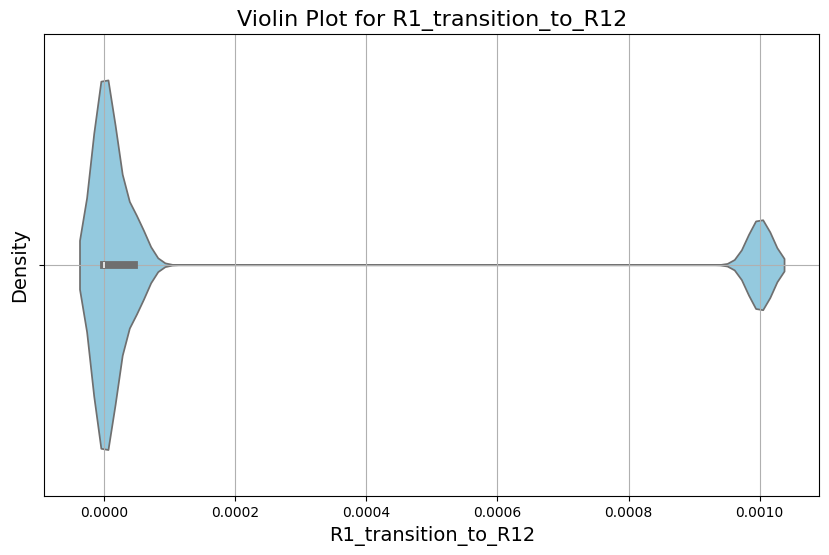

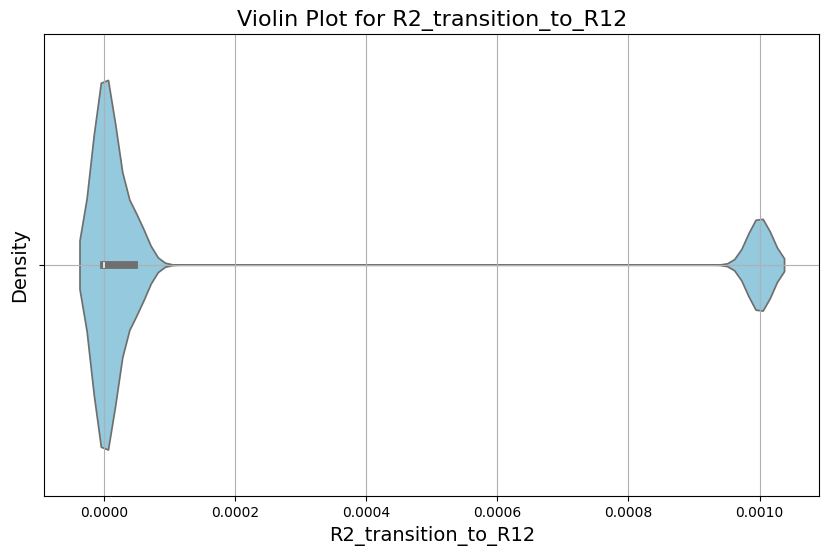

<ipython-input-4-c509f9074e32>:222: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ec_category_distribution.keys()), y=list(ec_category_distribution.values()), palette="pastel")


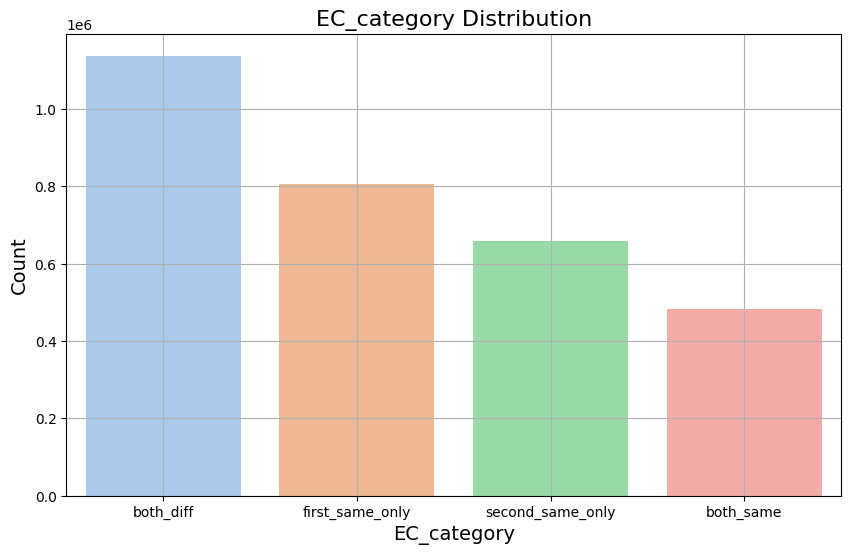

{'Survival_CPM': {'min': 0.0,
  'max': 1440.0,
  'mean': np.float64(334.0392536016577),
  'median': 180.0,
  'std': 365.4892874321312},
 'Survival_DPM': {'min': 0.0,
  'max': 1845.0,
  'mean': np.float64(671.4543029994813),
  'median': 360.0,
  'std': 676.1879919814648},
 'Survival_DPMtrial': {'min': 0.0,
  'max': 1845.0,
  'mean': np.float64(630.8449669551409),
  'median': 315.0,
  'std': 658.7769473819935},
 'S_pop': {'min': 0.0,
  'max': 5000000000.0,
  'mean': np.float64(3534292205.357169),
  'median': 4500000000.0,
  'std': 2006464883.0872214},
 'R1_pop': {'min': 0.0,
  'max': 4500000000.0,
  'mean': np.float64(776166103.725938),
  'median': 50000.0,
  'std': 1593422121.4589496},
 'R2_pop': {'min': 0.0,
  'max': 4500000000.0,
  'mean': np.float64(689544318.1613699),
  'median': 50000.0,
  'std': 1516729439.3330624},
 'R12_pop': {'min': 0.0,
  'max': 0.0,
  'mean': np.float64(0.0),
  'median': 0.0,
  'std': 0.0},
 'g0': {'min': 0.007,
  'max': 0.34,
  'mean': np.float64(0.158674136

In [ ]:
wholeTrialPopulation.calculate_statistics()

The function "add_benefit_columns()" will calculate the benefit of DPM drug selection compared to CPM drug selection for each simlated patients. The default benefit is defined as at least an increase of 60 days with DPM over CPM (min_survival_days=60) and that improvement is at least 25% ("min_percent_benefit=25").

The function adds the columns "benefit_DPM", "benefit_DPMtrial", and finally "Extraordinary_Benefit" which calculates the benefit of DPM vs DPMtrial. Those with Extraordinary Benefit recienve further benefit from continued DPM.

These columns are boolean, indicating if the particular combination of parameters benefits from the application of DPM.

In [ ]:
wholeTrialPopulation.add_benefit_columns()

The New columns are added to the trial population data.

In [ ]:
wholeTrialPopulation.to_dataframe().head()

,Parameter_ID,Survival_CPM,Survival_DPM,Survival_DPMtrial,EC_category,S_pop,R1_pop,R2_pop,R12_pop,g0,...,R2_cell_sensitivity_D2,R12_cell_sensitivity_D1,R12_cell_sensitivity_D2,S_transition_to_R1,S_transition_to_R2,R1_transition_to_R12,R2_transition_to_R12,benefit_DPM,benefit_DPMtrial,Extraordinary_Benefit
0,39157981,1350.0,1530.0,1530.0,both_diff,0.000000e+00,4.500000e+09,500000000.0,0.0,0.0184,...,8.428000e-06,0.000000e+00,8.428000e-06,1.000000e-07,4.642000e-09,4.642000e-09,1.000000e-07,False,False,False
1,25167750,1125.0,1260.0,1260.0,both_diff,4.995000e+09,5.000000e+06,500.0,0.0,0.0184,...,1.548500e-05,8.096000e-05,1.548500e-05,1.000000e-07,1.000000e-03,1.000000e-03,1.000000e-07,False,False,False
2,38341635,1350.0,1350.0,1350.0,both_same,4.950000e+08,4.500000e+09,5000000.0,0.0,0.0184,...,4.371800e-07,0.000000e+00,4.371800e-07,4.642000e-09,1.000000e-07,1.000000e-07,4.642000e-09,False,False,False
3,35871455,1170.0,1170.0,1170.0,both_same,5.000000e+08,4.500000e+09,5.0,0.0,0.0184,...,3.998500e-05,8.096000e-05,3.998500e-05,1.000000e-07,2.154000e-06,2.154000e-06,1.000000e-07,False,False,False
4,38195757,1395.0,1665.0,1395.0,both_same,4.950000e+08,4.500000e+09,5000000.0,0.0,0.0070,...,1.968000e-03,3.337800e-07,1.968000e-03,2.154000e-10,4.642000e-05,4.642000e-05,2.154000e-10,False,False,False


# Subsetting Population

The trial population can be subset by the "EC_category" Value. The method returns the subset as a TrailPopulation Object.

In [ ]:
#second_same_pop = wholeTrialPopulation.subset_by_ec_category(['second_same_only'], population_id='Second_Same_Only')
#first_same_pop = wholeTrialPopulation.subset_by_ec_category(['first_same_only'], population_id='First_Same_Only')
ec1_pop = wholeTrialPopulation.subset_by_ec_category(['second_same_only', 'both_diff'], population_id='EC1')

The methods used to characterize the population can also be used on the subset.

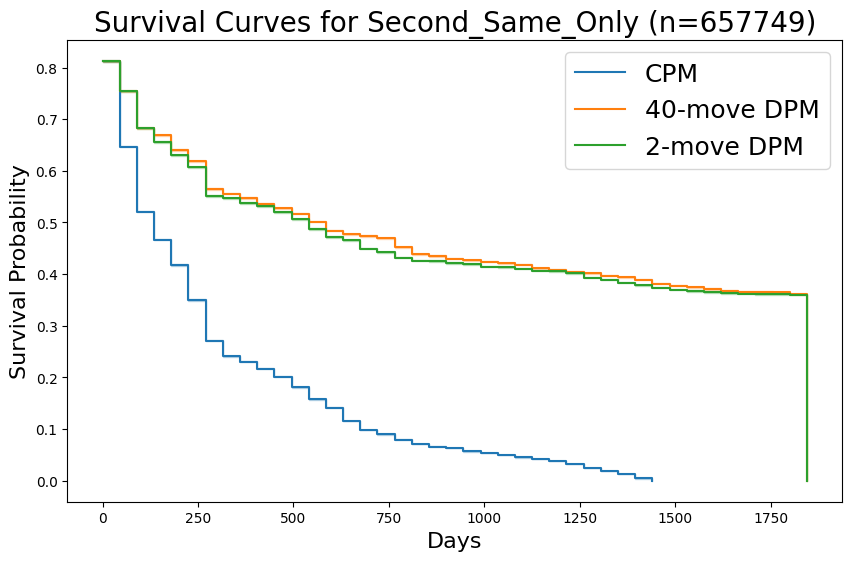

In [ ]:
second_same_pop.plot_km()

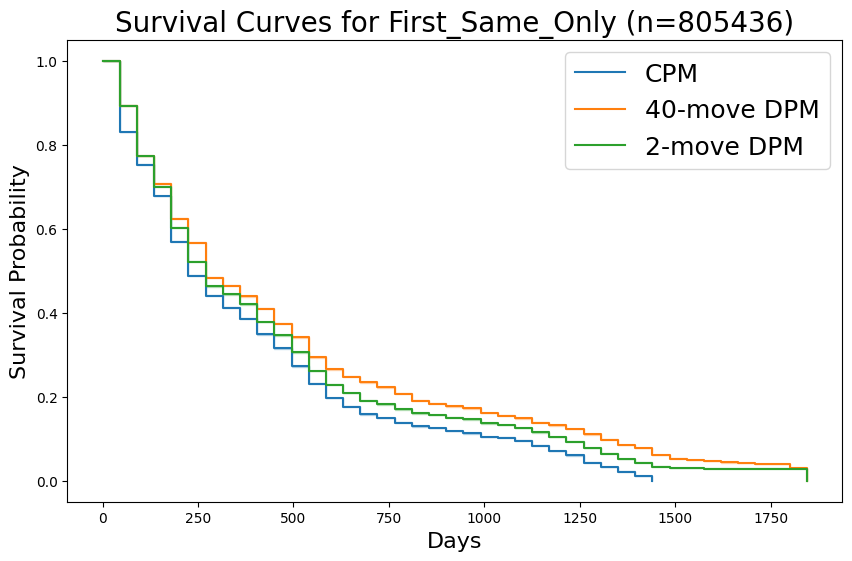

In [ ]:
first_same_pop.plot_km()

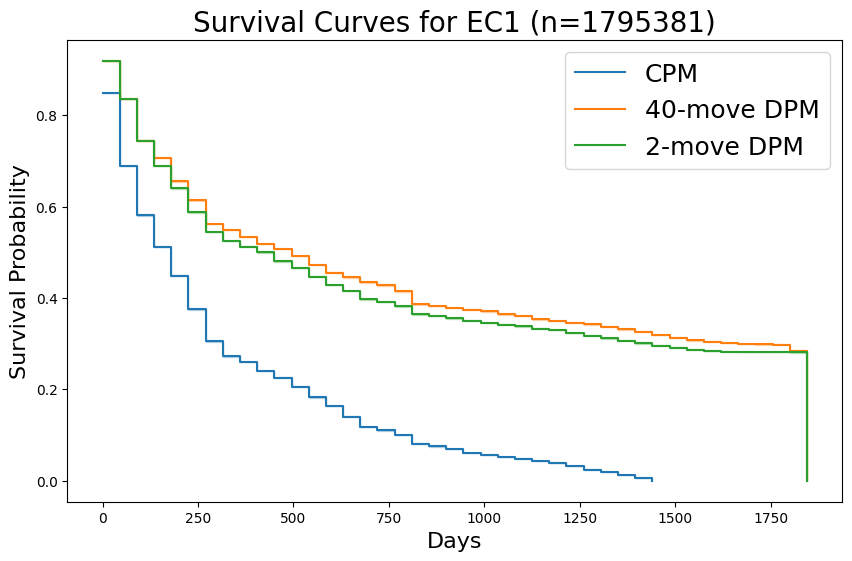

In [ ]:
ec1_pop.plot_km()

The subset population can be saved by providing a file name ot the "to_datafame()" method.

In [ ]:
second_same_pop.add_benefit_columns()
second_same_pop.to_dataframe(os.path.join(sim_data_dir, 'second_same_pop.csv'))

,Parameter_ID,Survival_CPM,Survival_DPM,Survival_DPMtrial,EC_category,S_pop,R1_pop,R2_pop,R12_pop,g0,...,R2_cell_sensitivity_D2,R12_cell_sensitivity_D1,R12_cell_sensitivity_D2,S_transition_to_R1,S_transition_to_R2,R1_transition_to_R12,R2_transition_to_R12,benefit_DPM,benefit_DPMtrial,Extraordinary_Benefit
0,31758381,1215.0,1440.0,1395.0,second_same_only,4.500000e+09,5.000000e+08,50000.0,0.0,0.0184,...,0.000000,0.000081,0.000000,2.154000e-10,2.154000e-06,2.154000e-06,2.154000e-10,False,False,False
1,24346894,1305.0,1575.0,1530.0,second_same_only,4.995000e+09,5.000000e+06,5.0,0.0,0.0184,...,0.000006,0.000774,0.000006,4.642000e-09,4.642000e-05,4.642000e-05,4.642000e-09,False,False,False
2,27628477,1395.0,1665.0,1620.0,second_same_only,4.495000e+09,5.000000e+06,500000000.0,0.0,0.0184,...,0.000771,0.000000,0.000771,1.000000e-07,4.642000e-09,4.642000e-09,1.000000e-07,False,False,False
3,37372492,1395.0,1665.0,1350.0,second_same_only,4.999500e+08,4.500000e+09,50000.0,0.0,0.0070,...,0.000021,0.000003,0.000021,1.000000e-03,1.000000e-07,1.000000e-07,1.000000e-03,False,False,False
4,27645308,1170.0,1800.0,1665.0,second_same_only,4.495000e+09,5.000000e+06,500000000.0,0.0,0.0184,...,0.007405,0.000000,0.007405,1.000000e-03,4.642000e-05,4.642000e-05,1.000000e-03,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657744,39271293,270.0,360.0,360.0,second_same_only,0.000000e+00,4.500000e+09,500000000.0,0.0,0.0487,...,0.000150,0.000022,0.000150,1.000000e-03,4.642000e-05,4.642000e-05,1.000000e-03,True,True,False
657745,39272419,450.0,630.0,585.0,second_same_only,0.000000e+00,4.500000e+09,500000000.0,0.0,0.0487,...,0.013760,0.019407,0.013760,1.000000e-03,2.154000e-06,2.154000e-06,1.000000e-03,True,True,False
657746,39271873,360.0,405.0,405.0,second_same_only,0.000000e+00,4.500000e+09,500000000.0,0.0,0.0487,...,0.000002,0.002040,0.000002,4.642000e-05,2.154000e-06,2.154000e-06,4.642000e-05,False,False,False
657747,39271634,315.0,405.0,405.0,second_same_only,0.000000e+00,4.500000e+09,500000000.0,0.0,0.0487,...,0.000150,0.000213,0.000150,1.000000e-03,1.000000e-07,1.000000e-07,1.000000e-03,True,True,False


You can also subset the population by any of the continous valued columns.

To do this, the colulmn name is input to the "subset_pop_by_param()" method, along with the min and max values of that parameter.

Example:

> trialPopulation.subset_pop_by_params(param_col_name_1=(min, max), param_col_name_2=(min, max))



In [ ]:
# Create a subset where Survival_CPM is between 100 and 200, and g0 is less than 0.5
subset_01 = wholeTrialPopulation.subset_pop_by_params(Survival_CPM=(100, 200), g0=(0, 0.5))



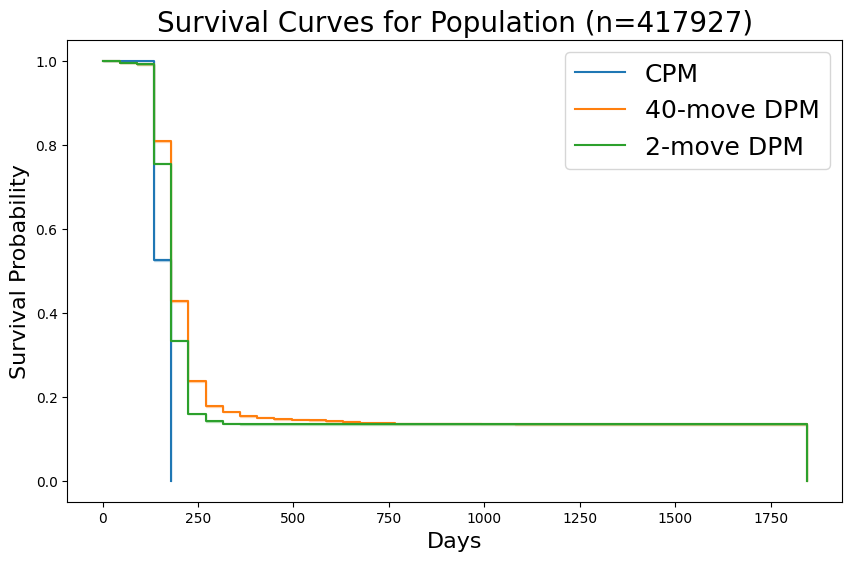

In [ ]:
subset_01.plot_km()

In [ ]:
subset_01.to_dataframe()
#

,Parameter_ID,Survival_CPM,Survival_DPM,Survival_DPMtrial,EC_category,S_pop,R1_pop,R2_pop,R12_pop,g0,...,R1_cell_sensitivity_D1,R1_cell_sensitivity_D2,R2_cell_sensitivity_D1,R2_cell_sensitivity_D2,R12_cell_sensitivity_D1,R12_cell_sensitivity_D2,S_transition_to_R1,S_transition_to_R2,R1_transition_to_R12,R2_transition_to_R12
0,14798751,135.0,315.0,225.0,both_diff,4.999900e+09,5.000000e+02,50000.0,0.0,0.3400,...,0.135490,0.31147,15.574,0.000000,0.135490,0.000000,4.642000e-09,4.642000e-09,4.642000e-09,4.642000e-09
1,7386904,135.0,675.0,270.0,both_diff,5.000000e+09,5.000000e+00,5.0,0.0,0.3400,...,0.135490,0.31147,15.574,0.000003,0.135490,0.000003,2.154000e-10,1.000000e-11,1.000000e-11,2.154000e-10
2,16446018,135.0,405.0,225.0,both_diff,4.500000e+09,5.000000e+02,500000000.0,0.0,0.3400,...,0.135490,0.31147,15.574,0.002710,0.135490,0.002710,1.000000e-11,2.154000e-10,2.154000e-10,1.000000e-11
3,9857799,135.0,540.0,225.0,first_same_only,4.995000e+09,5.000000e+00,5000000.0,0.0,0.3400,...,0.135490,0.31147,15.574,0.249180,0.135490,0.249180,2.154000e-06,1.000000e-11,1.000000e-11,2.154000e-06
4,7386914,135.0,360.0,225.0,both_diff,5.000000e+09,5.000000e+00,5.0,0.0,0.3400,...,0.135490,0.31147,15.574,0.000003,0.135490,0.000003,4.642000e-09,1.000000e-07,1.000000e-07,4.642000e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417922,24564922,180.0,270.0,225.0,both_diff,4.995000e+09,5.000000e+06,5.0,0.0,0.1287,...,0.000000,0.43446,5.895,0.036365,0.000000,0.036365,1.000000e-03,2.154000e-06,2.154000e-06,1.000000e-03
417923,24565712,180.0,1845.0,1845.0,both_diff,4.995000e+09,5.000000e+06,5.0,0.0,0.1287,...,0.005392,0.43446,5.895,0.000004,0.005392,0.000004,1.000000e-11,1.000000e-07,1.000000e-07,1.000000e-11
417924,36918562,180.0,180.0,180.0,first_same_only,5.000000e+08,4.500000e+09,500.0,0.0,0.1287,...,0.000564,0.43446,5.895,0.000042,0.000564,0.000042,1.000000e-11,4.642000e-09,4.642000e-09,1.000000e-11
417925,31977003,180.0,180.0,180.0,second_same_only,4.500000e+09,5.000000e+08,50000.0,0.0,0.1287,...,0.000059,0.43446,5.895,0.000042,0.000059,0.000042,1.000000e-03,4.642000e-09,4.642000e-09,1.000000e-03


For a simulated trial, first subset the whole population into subsets that represent the different arms. These can be defined by EC_category and parameter value threshold (single or complex).

To generate the trial population, randomly select from the subset population. The survival for that patient will be either Survival_CPM, Survival_DPM. or Survival_DPMtrial, depeding on which treatment strategy is being tested in that arm.